<a href="https://colab.research.google.com/github/Jabaananth/Shopper-Spectrum_Recommendations-in-E-Commerce/blob/main/Recommendation_E_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Recommendation E_commerce***

# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import datetime as dt

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/online_retail.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [5]:
data.shape

(541909, 8)

# Remove missing Customer IDs

In [6]:
data = data[pd.notnull(data['CustomerID'])]
data.shape

(406829, 8)

# Remove canceled transactions (InvoiceNo starting with 'C')

In [7]:
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]

In [8]:
data.shape

(397924, 8)

In [9]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


# Create 'TotalAmount' column

In [10]:
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Type casting

In [11]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].dtype

dtype('<M8[ns]')

# Set reference date for recency calculation (max invoice date)

In [12]:
reference_date = data['InvoiceDate'].max()
reference_date

Timestamp('2023-12-09 12:50:00')

# Compute RFM

# RFM-Recency,Frequency, Monetary

In [13]:
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

# Rename columns

In [14]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


# Distribution

In [15]:
rfm.skew()

,0
CustomerID,0.001433
Recency,1.246357
Frequency,12.100028
Monetary,19.326985


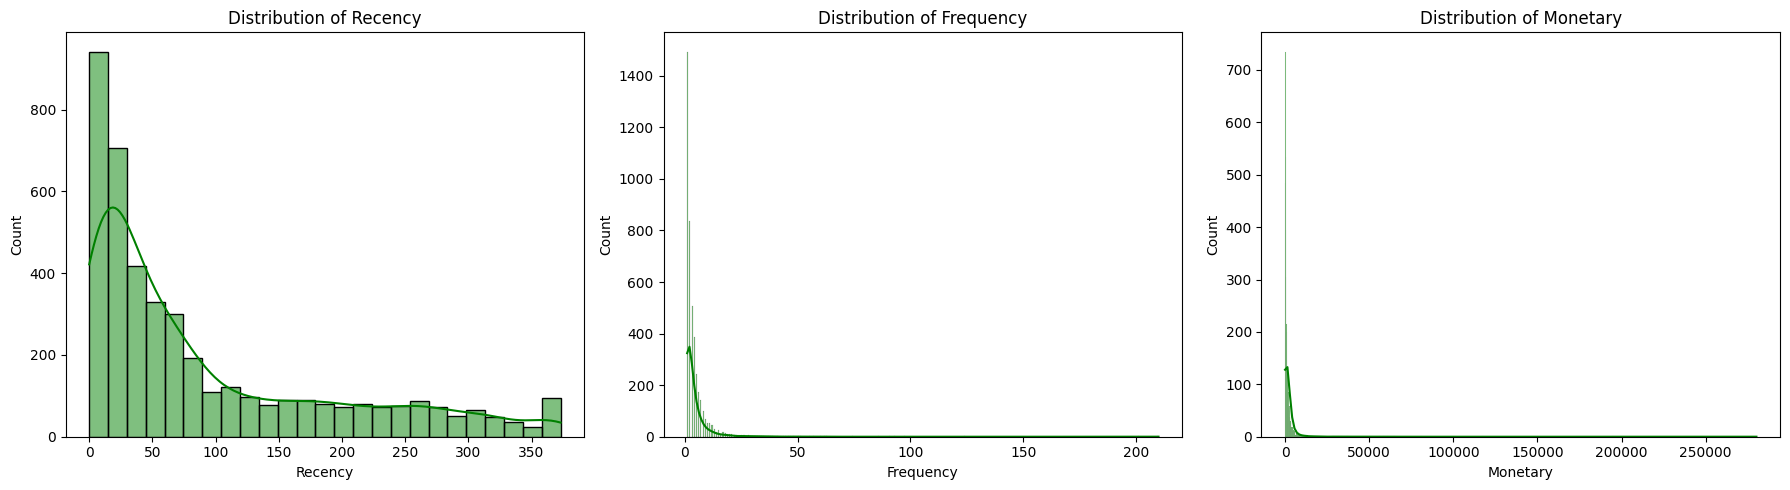

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

rfm_cols = ['Recency', 'Frequency', 'Monetary']

plt.figure(figsize=(18,5))

for i, col in enumerate(rfm_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], kde=True, color='green')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [18]:
from sklearn.cluster import KMeans

# Use Elbow method / silhouette score to find optimal clusters (let's assume 4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Add cluster labels
rfm['Cluster'] = kmeans.labels_

rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,1,77183.60,0
1,12347.0,1,7,4310.00,3
2,12348.0,74,4,1797.24,3
3,12349.0,18,1,1757.55,3
4,12350.0,309,1,334.40,1


In [19]:
rfm.groupby('Cluster').mean()


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15201.928910,14.672986,22.047393,12453.225924
1,15344.258004,247.564030,1.551789,478.107581
2,15435.000000,6.384615,82.692308,127338.313846
3,15290.717982,42.910580,3.655748,1349.698298


In [20]:
rfm.groupby('Cluster').mean().sort_values('Monetary', ascending=False)

,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
2,15435.000000,6.384615,82.692308,127338.313846
0,15201.928910,14.672986,22.047393,12453.225924
3,15290.717982,42.910580,3.655748,1349.698298
1,15344.258004,247.564030,1.551789,478.107581


In [21]:
# | Cluster | Segment              | Characteristics (Typical)                  |
# | ------- | -------------------- | ------------------------------------------ |
# | 0       | High-Value Customers | Low recency, high frequency, high monetary |
# | 1       | Regular Customers    | Moderate recency/frequency/monetary        |
# | 2       | Occasional Shoppers  | Higher recency, low frequency/monetary     |
# | 3       | At-Risk Customers    | Very high recency, low frequency/monetary  |


In [22]:
# Define mapping dictionary
cluster_labels = {
    0: 'High-Value Customers',
    1: 'Regular Customers',
    2: 'Occasional Shoppers',
    3: 'At-Risk Customers'
}

# Map cluster labels
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# View result
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,325,1,77183.60,0,High-Value Customers
1,12347.0,1,7,4310.00,3,At-Risk Customers
2,12348.0,74,4,1797.24,3,At-Risk Customers
3,12349.0,18,1,1757.55,3,At-Risk Customers
4,12350.0,309,1,334.40,1,Regular Customers


<Axes: title={'center': 'Customer Segments'}, ylabel='count'>

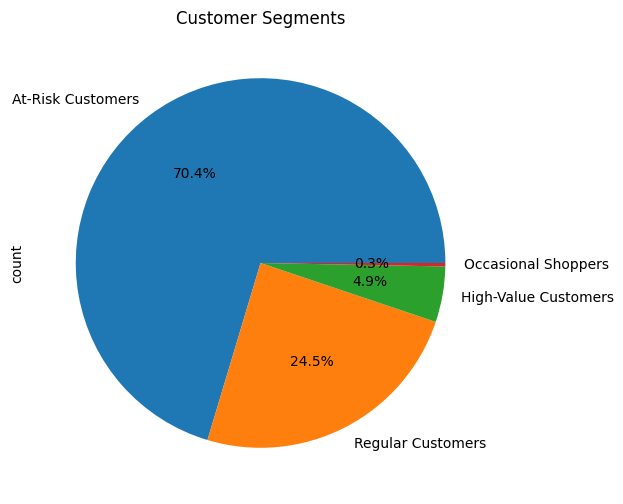

In [23]:
rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6), title='Customer Segments')


In [24]:
# Filter only High-Value Customers
high_value = rfm[rfm['Segment'] == 'High-Value Customers']

# Get min and max of RFM values
range_summary = high_value[['Recency', 'Frequency', 'Monetary']].agg(['min', 'max'])
print(range_summary)


     Recency  Frequency  Monetary
min        0          1   1296.44
max      371         93  77183.60


In [25]:
rfm['Segment'].value_counts()

,count
Segment,
At-Risk Customers,3053
Regular Customers,1062
High-Value Customers,211
Occasional Shoppers,13


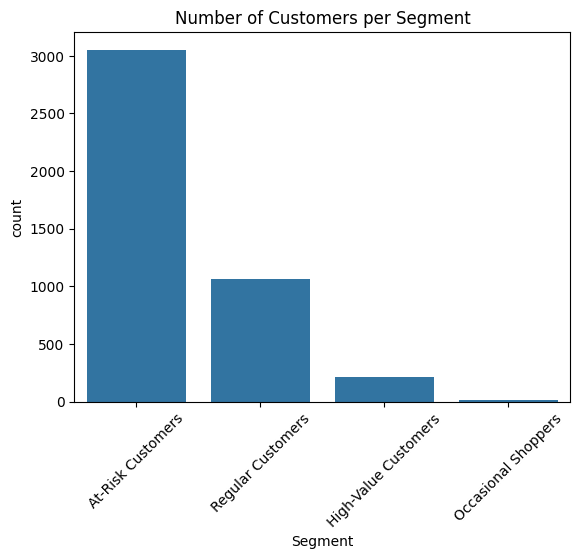

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Number of Customers per Segment")
plt.show()


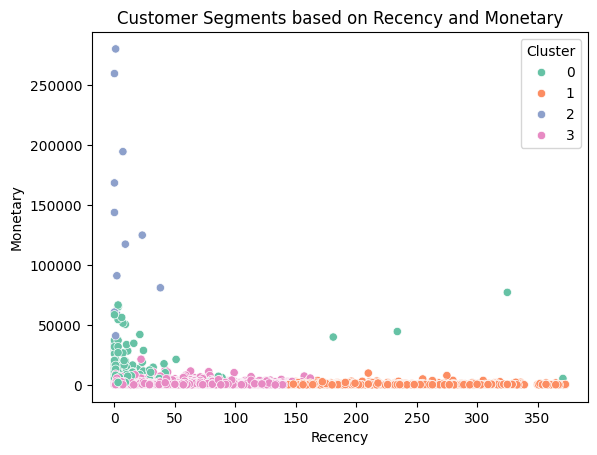

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='Set2')
plt.title("Customer Segments based on Recency and Monetary")
plt.show()


In [28]:
from sklearn.metrics import silhouette_score

silhouette_score(rfm_scaled, kmeans.labels_)


np.float64(0.6161144819517276)

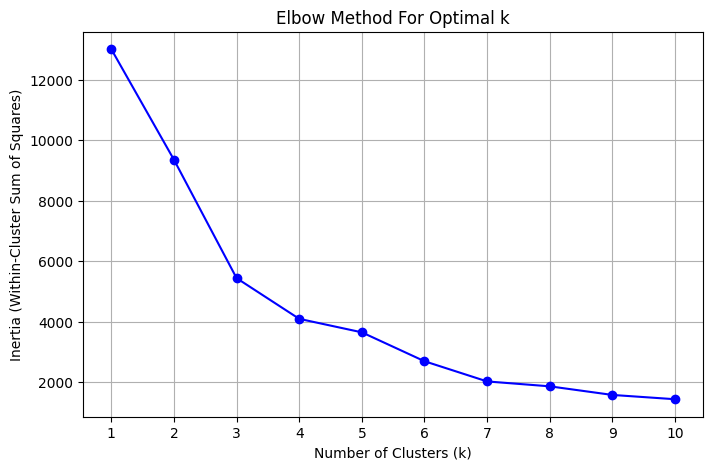

In [29]:
# Run KMeans for a range of cluster counts and record the inertia
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.grid(True)
plt.show()

In [30]:
import pickle

# Save KMeans model
with open('/content/drive/MyDrive/Colab Notebooks/rfm_kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Save Scaler
with open('/content/drive/MyDrive/Colab Notebooks/rfm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)



# Recommendation (Item-based collaborative filtering)

✅ Step 1: Create Item-User Matrix

In [46]:
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [48]:
import pandas as pd

# Create a pivot table: rows=product, columns=customer, values=quantity purchased
item_user_matrix = data.pivot_table(index='Description',
                                    columns='CustomerID',
                                    values='Quantity',
                                    aggfunc='sum')

# Fill NaN with 0
item_user_matrix.fillna(0, inplace=True)
item_user_matrix.to_pickle('/content/drive/MyDrive/Colab Notebooks/item_user_matrix.pkl')



✅ Step 2: Compute Cosine Similarity Between Items

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between products (item-item similarity)
item_similarity = pd.DataFrame(cosine_similarity(item_user_matrix),
                                index=item_user_matrix.index,
                                columns=item_user_matrix.index)


In [33]:
def recommend_products(product_name, n=5):
    if product_name not in item_similarity.columns:
        return "Product not found in the catalog."

    # Sort products by similarity score descending
    similar_products = item_similarity[product_name].sort_values(ascending=False)

    # Exclude the input product itself
    recommended_products = similar_products.iloc[1:n+1].index.tolist()

    return recommended_products


In [34]:
recommend_products('WHITE HANGING HEART T-LIGHT HOLDER', 5)


['GIN + TONIC DIET METAL SIGN',
 'RED HANGING HEART T-LIGHT HOLDER',
 'WASHROOM METAL SIGN',
 'LAUNDRY 15C METAL SIGN',
 'GREEN VINTAGE SPOT BEAKER']

In [35]:
item_similarity.to_csv('/content/drive/MyDrive/Colab Notebooks/item_similarity.csv')


# Streamlit

In [36]:
!pip install streamlit streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


In [60]:
%%writefile app.py

import pickle
import streamlit as st
import pandas as pd
from streamlit_option_menu import option_menu

# Load models
with open('/content/drive/MyDrive/Colab Notebooks/rfm_kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/rfm_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


# Sidebar menu
with st.sidebar:
    selected = option_menu(
        menu_title="Home",
        options=["Clustering", "Recommendation"],
        icons=["graph-up", "cart"],
        menu_icon="cast",
        default_index=0
    )

# -----------------------------
# 📊 CLUSTERING SECTION
# -----------------------------
if selected == "Clustering":
    st.title("🧮 Customer Segmentation")

    recency = st.number_input("Recency (days since last purchase)", min_value=0)
    frequency = st.number_input("Frequency (number of purchases)", min_value=0)
    monetary = st.number_input("Monetary (total spend)", min_value=0.0)


    cluster_labels = {
         0: 'High-Value Customers',
         1: 'Regular Customers',
         2: 'Occasional Shoppers',
         3: 'At-Risk Customers'
         }

    if st.button("Predict Segment"):

        user_scaled = scaler.transform([[recency, frequency, monetary]])
        cluster_number = kmeans.predict(user_scaled)[0]
        cluster_name = cluster_labels[int(cluster_number)]


        st.success(f"Prediction: {cluster_name}")


# -----------------------------
# 🛍️ RECOMMENDATION SECTION
# -----------------------------
elif selected == "Recommendation":
    item_similarity = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/item_similarity.csv', index_col=0)
    product_list = item_similarity.columns.tolist()

    st.title("🛍️ Product Recommendation System")
    selected_product = st.selectbox("Select a Product", product_list)

    if selected_product:
        if selected_product not in item_similarity.columns:
            st.error("Selected product not found in the similarity matrix.")
        else:
            recommendations = item_similarity[selected_product].sort_values(ascending=False)[1:6]
            st.subheader("Top 5 Recommended Products:")
            for product, score in recommendations.items():
                st.write(f"- {product} (Similarity: {score:.2f})")


Overwriting app.py


In [61]:
!wget -q -O - ipv4.icanhazip.com

34.126.77.208


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.77.208:8501

⠸⠼⠴⠦⠧⠇your url is: https://chilly-onions-check.loca.lt
